# Statistics studies

<br>
Created: 02.01.2024<br>
Melih Kara

Following the same lecture, practicing statistics. <br>
https://indico.desy.de/event/38671/contributions/140932/attachments/83039/109605/2023_07_03_Statisticsschool_DESY_with_solutions.pdf

In this notebook we follow some tasks to analyze mock-higgs data. <br>
We start by searching for an optimized window for the significance.

In [1]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import uproot
import scipy

In [2]:
rootfile = uproot.open("./StatTutorial-master/data/Histograms_fake.root")
higgs_expected = rootfile['h_m4l_Higgs125_fake;1'].to_numpy()
bg_expected = rootfile['h_m4l_ZZ_fake;1'].to_numpy()
observed_data = rootfile['h_m4l_data_fake;1'].to_numpy()

energies = higgs_expected[1][1:]
higgs_expected = higgs_expected[0]
bg_expected = bg_expected[0]
observed_data = observed_data[0]
energies.shape, higgs_expected.shape, bg_expected.shape, observed_data.shape

((3600,), (3600,), (3600,), (3600,))

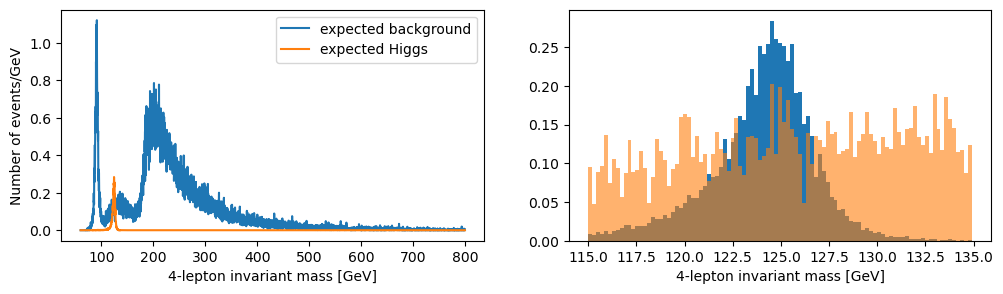

In [3]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,3))
ax1.plot(energies, bg_expected, label='expected background')
ax1.plot(energies, higgs_expected, label='expected Higgs')
emask = (energies<135)&(energies>115)
ax2.bar(energies[emask], higgs_expected[emask], label='expected Higgs', width=np.diff(energies[emask])[0])
ax2.bar(energies[emask], bg_expected[emask], label='expected background', alpha=0.6, width=np.diff(energies[emask])[0])
ax1.set_xlabel('4-lepton invariant mass [GeV]')
ax1.set_ylabel('Number of events/GeV')
ax2.set_xlabel('4-lepton invariant mass [GeV]')
ax1.legend();

Given this model, and observed data, what is the best window to look for expected counts in both null and alternative hypothesis? <br>
It is clear that if we take a large range, say, 10-800 GeV the expected counts from SM-only will be high, and comparison to SM+Higgs is not ideal. Instead, we need to define a window around the expected Higgs region and do an analysis around that.

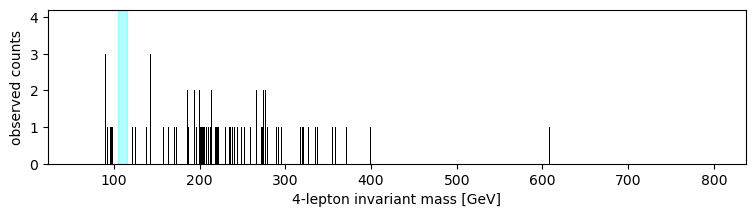

In [4]:
plt.figure(figsize=(9,2))
plt.bar(energies, observed_data, width=np.diff(energies)[0], color='k')
plt.xlabel('4-lepton invariant mass [GeV]'); plt.ylabel('observed counts')
plt.axvspan(105, 115, alpha=0.3, color='cyan'); # random, for visualization of the window

Now we need to define, **based on theory** the best window size to use for such comparison.

In [5]:
np.sum(observed_data)

396.0

as an example, 6 GeV window around 125GeV expected Higgs.

In [6]:
window = (energies < 125 + 3) & (energies > 125 - 3)
np.sum(higgs_expected[window]), np.sum(bg_expected[window]), np.sum(observed_data[window]), 

(5.0118976, 3.7561996, 11.0)

In this window, the expected background counts are 3.7, and expected Higgs events are ~5. <br>
So, the null hypothesis is ~4 counts<br>
Where alternative hypothesis is ~9 counts <br>
and the observed data is 11 counts. <br>

With this we can do a hypothesis test! However, let's first optimize this window, simply by doing a grid search.

In [7]:
mu_norm = 0
normal_dist = ss.norm(mu_norm)
x = np.linspace(-5,5,10000)
normal_pdf = normal_dist.pdf(x)

pvaltosigma = lambda p: abs(normal_dist.ppf(p))
sigmatopval = lambda s: 1-normal_dist.cdf(s)

In [8]:
def optimize_window(sampling_size=1000, scale_factor=1):
    significance_val_exp = np.zeros(sampling_size)
    significance_val_obs = np.zeros(sampling_size)

    for i, window_i in enumerate(np.linspace(0.1, 25, sampling_size)):
        window = (energies < 125 + window_i/2) & (energies > 125-window_i/2)
        total_exp_higgs = np.sum(higgs_expected[window]) * scale_factor
        total_exp_bg = np.sum(bg_expected[window]) * scale_factor
        total_obs_data = np.sum(observed_data[window]) * scale_factor

        pval_expected = ss.poisson.pmf(k=int(total_exp_bg+total_exp_higgs), mu=total_exp_bg)
        significance_expected = pvaltosigma(pval_expected) 

        pval_observed = ss.poisson.pmf(k=int(total_obs_data), mu=total_exp_bg)
        significance_observed = pvaltosigma(pval_observed)

        significance_val_exp[i] = significance_expected
        significance_val_obs[i] = significance_observed
    return significance_val_exp, significance_val_obs

In [9]:
sampling_size = 1000
scale_factor = 1
significance_val_exp, significance_val_obs = optimize_window(sampling_size, scale_factor)

3.19 sigma in observed data


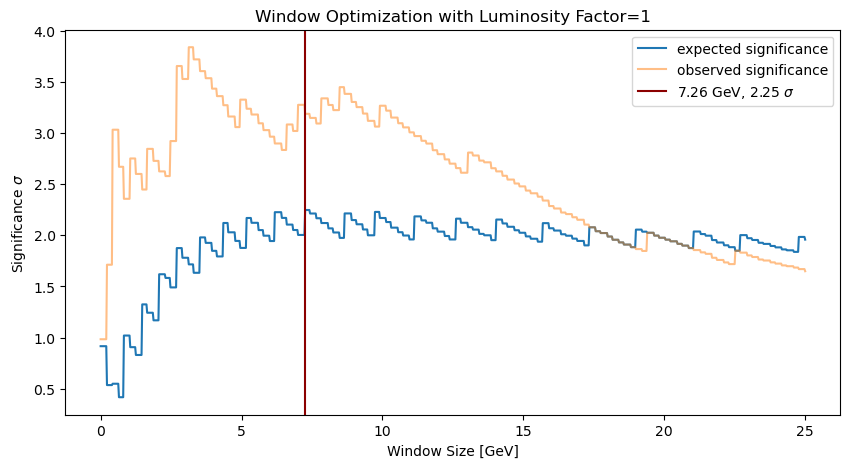

In [10]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,25,sampling_size), significance_val_exp, label='expected significance')
plt.plot(np.linspace(0,25,sampling_size), significance_val_obs, label='observed significance', alpha=0.5)

best_window = np.linspace(0,25,sampling_size)[np.where(significance_val_exp==np.max(significance_val_exp))][0]

plt.title(f"Window Optimization with Luminosity Factor=1")
plt.axvline(best_window, color='darkred', label=fr"{best_window:.2f} GeV, {np.max(significance_val_exp):.2f} $\sigma$")
plt.xlabel("Window Size [GeV]"); plt.ylabel(r'Significance $\sigma$')
plt.legend();
print(fr"{significance_val_obs[np.where(np.linspace(0,25,sampling_size)==best_window)[0]][0]:.2f} sigma in observed data")

7.01 sigma in observed data


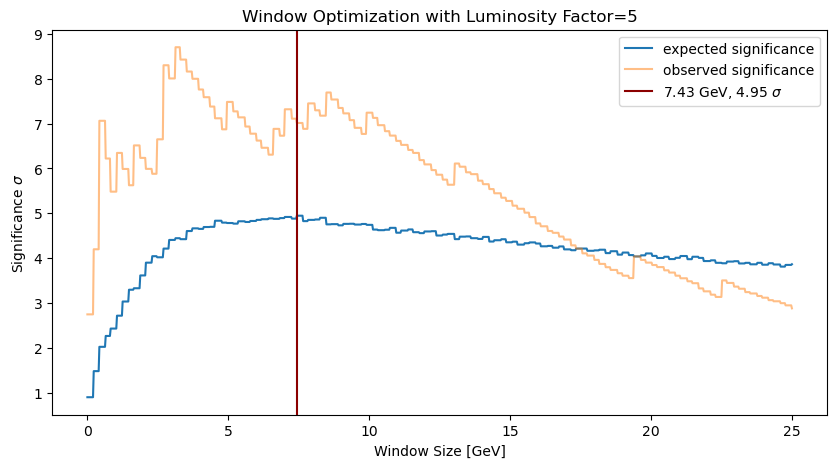

In [11]:
significance_val_exp, significance_val_obs = optimize_window(scale_factor=5)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,25,sampling_size), significance_val_exp, label='expected significance')
plt.plot(np.linspace(0,25,sampling_size), significance_val_obs, label='observed significance', alpha=0.5)

best_window = np.linspace(0,25,sampling_size)[np.where(significance_val_exp==np.max(significance_val_exp))][0]

plt.title(f"Window Optimization with Luminosity Factor=5")
plt.axvline(best_window, color='darkred', label=fr"{best_window:.2f} GeV, {np.max(significance_val_exp):.2f} $\sigma$")
plt.xlabel("Window Size [GeV]"); plt.ylabel(r'Significance $\sigma$')
plt.legend();
print(fr"{significance_val_obs[np.where(np.linspace(0,25,sampling_size)==best_window)[0]][0]:.2f} sigma in observed data")

So we need more than $\times5$ exposure to claim a discovery with $5\sigma$ _expected_ significance. Notice, that the observed significance is irrelevant as it comes from the data, and all optimization has to be done aprior to avoid biasing. <br>
Otherwise, it is also evident that a shorter window size could have given a higher significance in the observed data, but setting it to that value would be scientifically wrong.

### Background fluctuation

Notice that the background is also a model that could in principle flucatuate in the real observation. Is it possible that we see an upward fluctuation in the background-only model and think that we discovered Higgs? Can it mimic Higgs contribution? <br>

In order to understand this, we need to look at _side bands_ to see how much do the background only data (where we do not expect any Higgs contributions anyway) fluctuates.

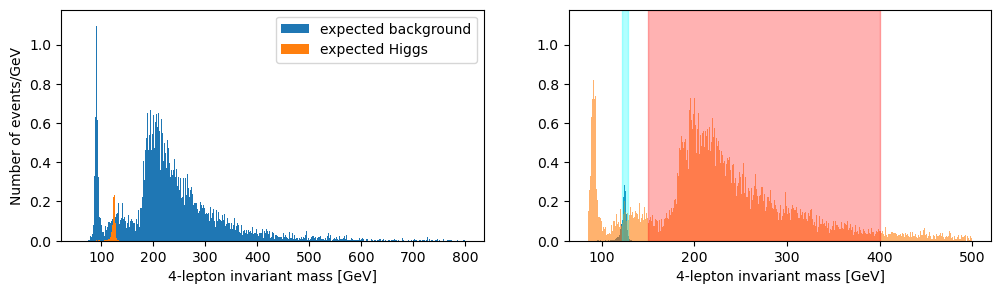

In [50]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,3))
ax1.bar(energies, bg_expected, label='expected background', width=np.diff(energies)[0])
ax1.bar(energies, higgs_expected, label='expected Higgs', width=np.diff(energies)[0])
emask = (energies<450)&(energies>85)
ax2.bar(energies[emask], higgs_expected[emask], width=np.diff(energies[emask])[0])
ax2.bar(energies[emask], bg_expected[emask], alpha=0.6, width=np.diff(energies[emask])[0])

ax2.axvspan(125-7.26/2, 125+7.26/2, alpha=0.3, color='cyan', label='signal region')
ax2.axvspan(150, 400, alpha=0.3, color='red', label='sideband')

ax1.set_xlabel('4-lepton invariant mass [GeV]')
ax1.set_ylabel('Number of events/GeV')
ax2.set_xlabel('4-lepton invariant mass [GeV]')
ax1.legend(); ax2.legend();

Rebin the data (for visualization & comparison with the pdf that I follow)

In [100]:
rb_energies = energies.reshape((180,20)).mean(1)
rb_observed_data = observed_data.reshape((180,20)).sum(1)
rb_higgs_expected = higgs_expected.reshape((180,20)).sum(1)
rb_bg_expected = bg_expected.reshape((180,20)).sum(1)

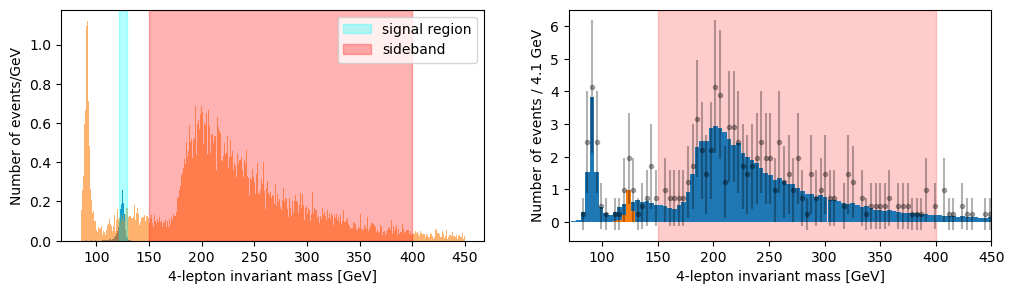

In [104]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,3))
emask = (energies<450)&(energies>85)
ax1.bar(energies[emask], higgs_expected[emask], width=np.diff(energies[emask])[0])
ax1.bar(energies[emask], bg_expected[emask], alpha=0.6, width=np.diff(energies[emask])[0])
ax1.axvspan(125-7.26/2, 125+7.26/2, alpha=0.3, color='cyan', label='signal region')
ax1.axvspan(150, 400, alpha=0.3, color='red', label='sideband')
ax1.set_xlabel('4-lepton invariant mass [GeV]')
ax1.set_ylabel('Number of events/GeV')

ax2.axvspan(150, 400, alpha=0.2, color='red', label='sideband')
ax2.errorbar(rb_energies[rb_observed_data>0], rb_observed_data[rb_observed_data>0]/4.1, 
             yerr=np.sqrt(rb_observed_data[rb_observed_data>0]/4.1), fmt='. k', alpha=0.3)
ax2.bar(rb_energies, rb_bg_expected/4.1, width=4.1)
ax2.bar(rb_energies, rb_higgs_expected/4.1, width=4.1)
ax2.set_xlim(70, 450)
ax2.set_ylabel('Number of events / 4.1 GeV')
ax2.set_xlabel('4-lepton invariant mass [GeV]')
ax1.legend();

Now let's try to find the best scaling factor by fitting the side band data to the model. <br>

$$f_{total} = \mu\cdot f_{\rm Higgs} + \alpha\cdot f_{\rm SM}$$

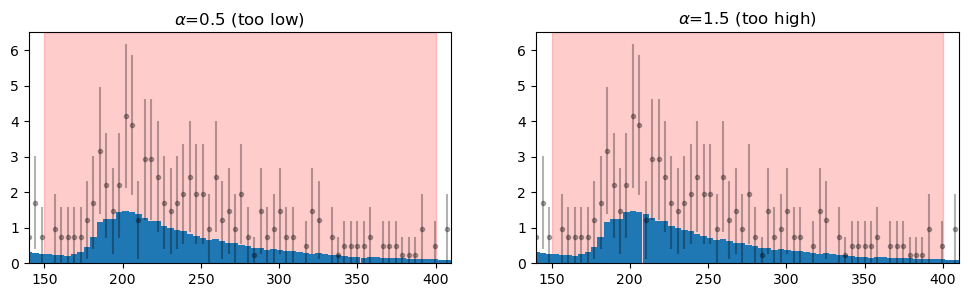

In [108]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,3))
for ax in [ax1, ax2]:
    ax.axvspan(150, 400, alpha=0.2, color='red', label='sideband')
    ax.errorbar(rb_energies[rb_observed_data>0], rb_observed_data[rb_observed_data>0]/4.1, 
                yerr=np.sqrt(rb_observed_data[rb_observed_data>0]/4.1), fmt='. k', alpha=0.3)
    ax.set_xlim(140,410)
    ax.set_ylim(0, None)
    
alpha1 = 0.5
ax1.bar(rb_energies, alpha1*rb_bg_expected/4.1, width=4.1)
ax1.set_title(fr"$\alpha$={alpha1} (too low)")
alpha2 = 1.5
ax2.bar(rb_energies, alpha1*rb_bg_expected/4.1, width=4.1)
ax2.set_title(fr"$\alpha$={alpha2} (too high)");

How do we find the appropriate alpha scale factor? We could try different alpha values, but then how are we gonna decide which of these alpha values is the best? To decide this, we will perform a likelihood test to see how compatible is the parameter with our measured data!

$$-2\log(L) = -2\cdot\sum_{bins}\log(\text{Poisson}(N_{bin}^{data}|\alpha\cdot f_{bin}^{SM}))$$

which we can read as; what is the lowest (since there is a negative) log value for the sum of all bins for a poisson probability of observing N data given the model is $\alpha\cdot f^{SM}$

### Likelihood Fitting
Here I'll take a step back and investigate the likelihood fitting methods for a simpler case first. Then, we continue with our Higgs discovery!

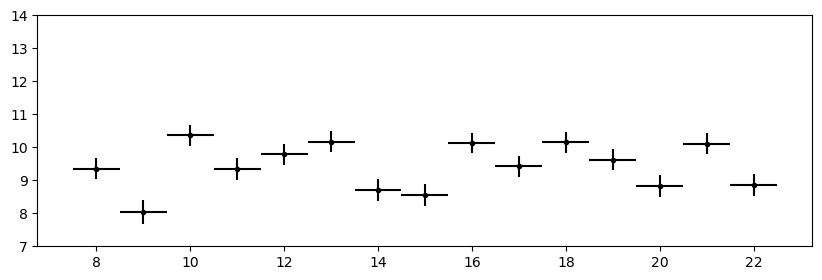

In [183]:
x = np.linspace(8, 22, 15)
y_true = 9.876
y = y_true + np.random.normal(size=15)
plt.figure(figsize=(10,3))
plt.errorbar(x, y, xerr=np.diff(x)[0]/2, yerr=1/np.sqrt(y), fmt=". k")
plt.ylim(7,14);

How do I fit such a data? Let's say our model is a simple straight 1-D line $f(x)=\lambda$ what is the value of $\lambda$?

 1) **$\chi^2$-fit**<br>
 $$\chi^2 = \sum_{hist} \frac{(N_{bin}^{data} - \lambda_{bin}^{expected})^2}{N_{bin}^{data}}$$
 Best value: the value of $\lambda$ that minimizes the $\chi^2$ <br>
 Uncertanties: Values of $\lambda$ for which $\chi^2 = \chi^2_{min} + 1 $
 
 2) **Likelihood-fit**<br>
 $$-2\log(L) = -2\cdot\sum_{bins}\log(\text{Poisson}(N_{bin}^{data}|\lambda))$$
 Best value: Value of $\lambda$ that minimizes the $2\log(L)$ i.e. $(2\log(L)_{min})$<br>
 Uncertainties: Values of $\lambda$ for which $2\log(L) = (2\log(L)_{min}) + 1$

Let's start with $\chi^2$ fit

9.80453506158817
9.62277027838658
9.577617602895351
9.532580335527786


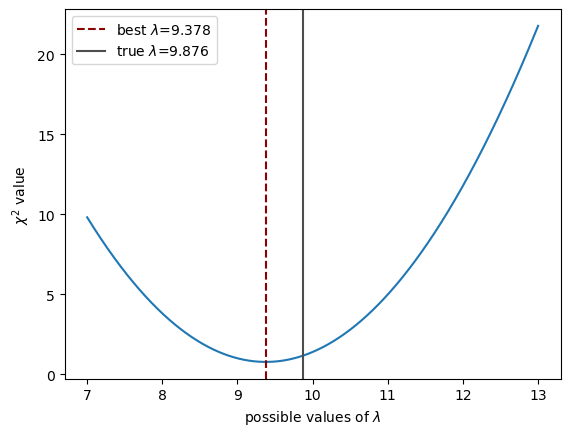

In [184]:
# chi-square fit
expected_values = np.linspace(7,13,1000)

# for understanding, step by step
null_test1 = (y[0] - expected_values[0])**2 / y[0]
null_test2 = np.sum([(i - expected_values[0])**2 / i for i in y])
print(null_test2)
for exv in expected_values[4:7]:
    print(np.sum([(i - exv)**2 / i for i in y]))

# do it properly    
chisquare = np.array([np.sum((y-exv)**2 / y) for exv in expected_values])
plt.plot(expected_values, chisquare)
best_lambda = expected_values[np.where(chisquare==np.min(chisquare))[0]]
plt.axvline(best_lambda, color='darkred', ls='--', label=fr'best $\lambda$={np.round(best_lambda[0],3)}')
plt.axvline(y_true, color='0.3', label=fr'true $\lambda$={y_true}')
plt.legend();
plt.xlabel(r'possible values of $\lambda$')
plt.ylabel(r'$\chi^2$ value');

Now let's do the likelihood fitting

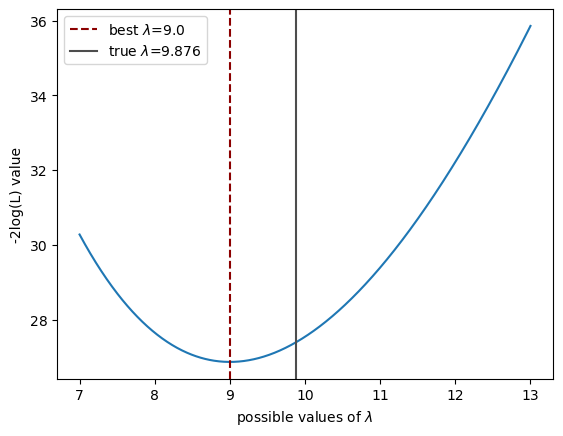

In [185]:
def get_nll(observed, expected):
    p = ss.poisson.pmf(k=observed.astype(int), mu=expected)
    return -2*np.sum(np.log10(p))

# expected_values
nll = [get_nll(y, exv) for exv in expected_values]
best_lambda = expected_values[np.where(nll==np.min(nll))[0]]
plt.plot(expected_values, nll)
plt.axvline(best_lambda, color='darkred', ls='--', label=fr'best $\lambda$={np.round(best_lambda[0],3)}')
plt.axvline(y_true, color='0.3', label=fr'true $\lambda$={y_true}')
plt.legend();
plt.xlabel(r'possible values of $\lambda$')
plt.ylabel(r'-2log(L) value');

CAVEAT: Notice here, I am using a poisson log likelihood fit eventhough the underlying true value is a floating number. Normally, in a counting experiment, you do not expect the underlying true value to be a floating number. Hence, here the performance is biased. 

#### Let's get back to Higgs Discovery

Now that we established a method to fit different model with different scaling factors, we can get back to Higgs discovery.

In [ ]:
nll_size = 200
nll_array = np.zeros(nll_size)

for i, alfa in enumerate(np.linspace(0,2,nll_size)):
    nll = get_nll(sb_observed_data, alfa*sb_bg_expected+sb_higgs_expected)
    nll_array[i] = nll

In [211]:
roi_mask = (energies > 150) & (energies < 400)
roi_energies = energies[roi_mask] 
roi_bg_expected = bg_expected[roi_mask]
roi_higgs_expected = higgs_expected[roi_mask]
print(np.sum(roi_higgs_expected))
roi_observed_data = observed_data[roi_mask]

alphas = np.linspace(0.1, 2, 100)
nll_arr = np.zeros(100)
for i, a in enumerate(alphas):
    expected_value = a*roi_bg_expected + roi_higgs_expected
    nll_arr[i] = get_nll(roi_observed_data, expected_value)

0.002599678


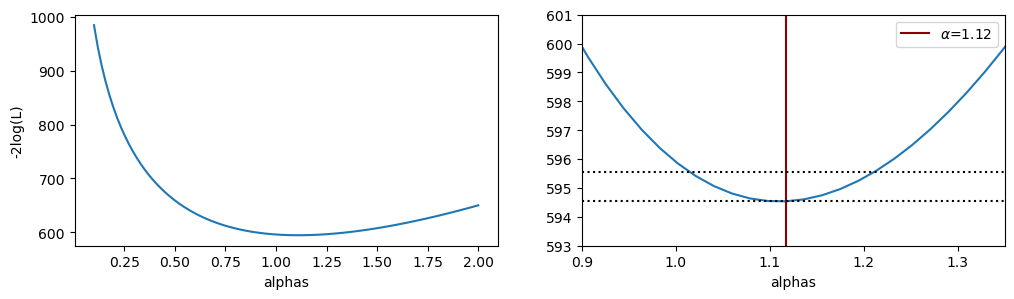

In [229]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,3))
ax1.plot(alphas, nll_arr)
ax2.plot(alphas, nll_arr)
best_alfa = alphas[np.where(nll_arr==np.min(nll_arr))[0]]
ax2.axvline(best_alfa, label=fr'$\alpha$={best_alfa[0]:.2f}', color='darkred')
nll_at_best_alfa = nll_arr[np.where(nll_arr==np.min(nll_arr))[0]]
ax2.axhline(nll_at_best_alfa, ls=':', color='k')
ax2.axhline(nll_at_best_alfa + 1, ls=':', color='k')
ax2.legend()
[ax.set_xlabel('alphas') for ax in [ax1,ax2]]
ax1.set_ylabel('-2log(L)')
ax2.set_xlim(0.9, 1.35); ax2.set_ylim(593, 601);

In [225]:
from scipy.interpolate import interp1d

In [230]:
# find out the errors +/-

intercept1 = interp1d(nll_arr[alphas<1.1], alphas[alphas<1.1], )(nll_at_best_alfa + 1/2)[0]
intercept2 = interp1d(nll_arr[alphas>1.1], alphas[alphas>1.1], )(nll_at_best_alfa + 1/2)[0]
print(intercept1, intercept2)
sigma_minus = (best_alfa - intercept1)[0]
sigma_plus = (intercept2 - best_alfa)[0]
print(f"sigma+ = {sigma_plus:.3f},\tsigma- = {sigma_minus:.3f}")

1.0423960418209095 1.1799449155838824
sigma+ = 0.063,	sigma- = 0.075


$$\alpha = 1.11^{+0.075}_{-0.063}$$